# One-line agents

Up until this point, you've used LangGraph's low-level syntax for defining individual nodes and edges and building-up the graph component-by-component. This can continue to serve you well as you progress to multi-modal systems, but for faster experimentation, switching to LangGraph's pre-built components can be a useful option.

**Re-run the two cells below to create the environment and define the tools.**

In [1]:
# !pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4

In [2]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)
        
        if not results:
            return "No results found on Wikipedia."
        
        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."], 
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """
    
    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."
    
    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date
    
    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days
    
    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."
    
    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

LangGraph's `create_react_agent()` function allows you to quickly instantiate a tool-calling agent from an LLM and a list of tools!

**Define a one-line conditional tool-calling agent using LangGraph's pre-built functionality.**

In [3]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

# Add three tools to the list: wikipedia_tool, stock_data_tool, and python_repl_tool
tools = [wikipedia_tool, stock_data_tool, python_repl_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

# Create an agent using the create_react_agent function
prompt = """
You are an assistant for research and analysis of Fortune 500 companies. You have access to three tools:
- A Wikipedia tool for retrieving factual summary information about companies
- A stock performance data tool for retrieving stock price information from local CSV files
- A Python tool for executing Python code, which is to be used for creating stock performance visualizations
"""

# Create an agent using the create_react_agent function
agent = create_react_agent(llm, tools=tools, name="finance_assistant", prompt=prompt)

This `agent` object is an already-compiled graph, so it can be visualized and interacted with in the same way as your previous graph to verify its equivalence:

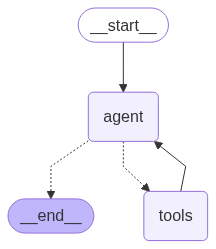

In [4]:
# Visualize your graph
agent

Here are the same prompts you tried with your graph with the conditional edge:

- Tell me about Apple Inc.
- AAPL stock price.
- My name is ...
- Plot an Open price time-series of AAPL.

In [5]:
from course_helper_functions import pretty_print_messages

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "Tell me Manus's current CEO, their latest stock price, and generate a plot of the closing price with the most up-to-date data you have available."}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: finance_assistant
Tool Calls:
  wikipedia_tool (call_jyKbXIE9Vb3wFH5hdIeLfLEY)
 Call ID: call_jyKbXIE9Vb3wFH5hdIeLfLEY
  Args:
    query: Manus Holdings CEO
  stock_data_tool (call_dLXDTYLL0l5pEOzHgU6jq87y)
 Call ID: call_dLXDTYLL0l5pEOzHgU6jq87y
  Args:
    company_ticker: MSX
    num_days: 30


Update from node tools:


================================= Tool Message =================================
Name: stock_data_tool

Sorry, but data for company MSX is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla.


Update from node tools:


================================= Tool Message =================================
Name: wikipedia_tool

Successfully executed:
Wikipedia summary: Alfred Music is an American music publishing company. Founded in New York in 1922, it is headquartered in Van Nuys, California, with additional branches in Miami, New York, G

Below are calls monitored in LangSmith. Use them to explore how it works behind the scene
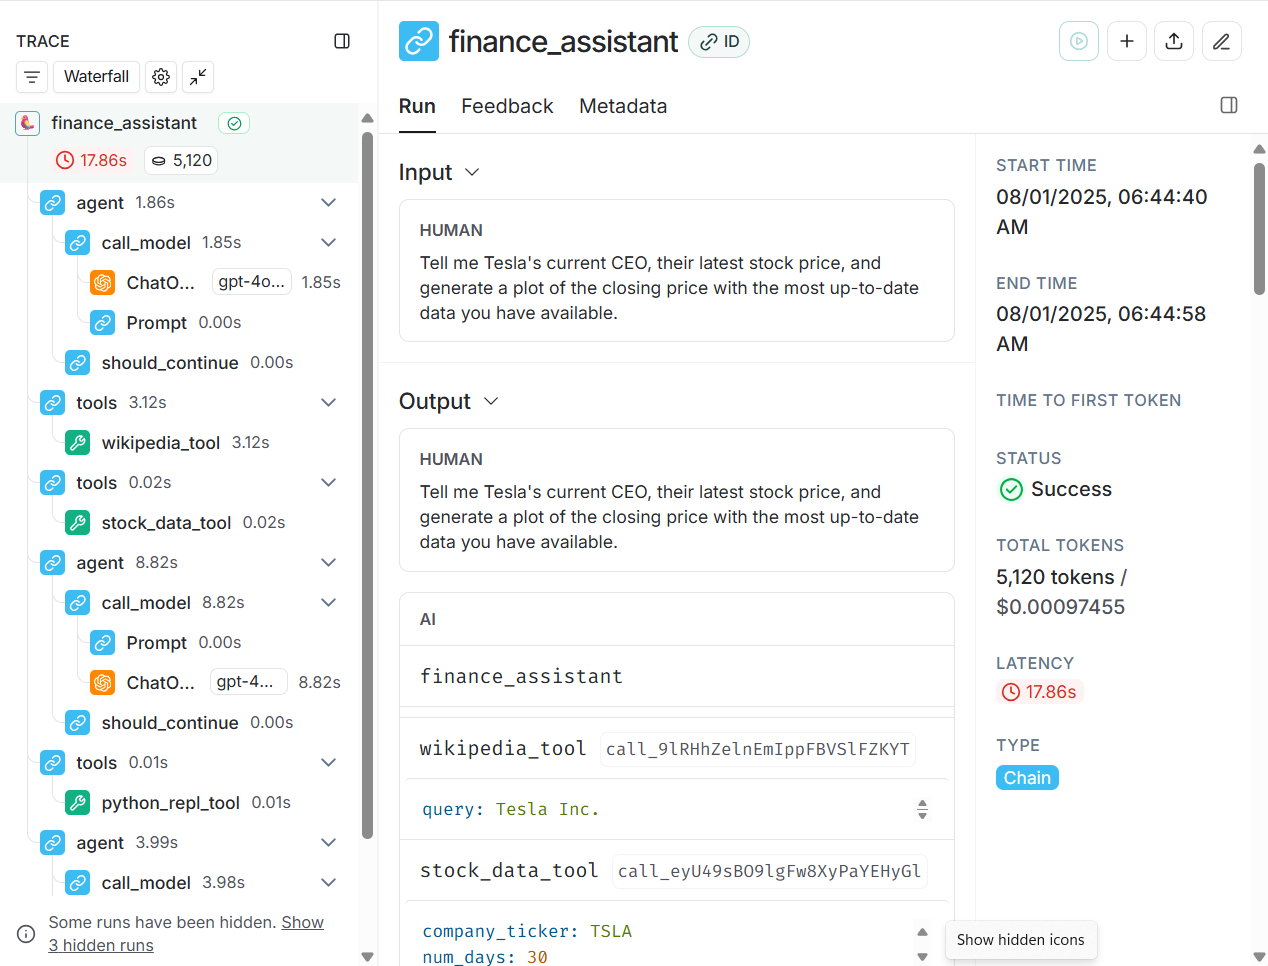

As we move into creating multi-agent systems, we'll use `create_react_agent()` so we can focus on connecting the agents together rather than creating each one individually. Once you've finished the course, you could even try refactoring your final multi-agent system using the lower-level syntax.

### 💡 What did we learn here?

- The `create_react_agent()` function is a useful utility for quickly creating a tool-calling agent, and we'll use this as we switch to creating multi-agent systems.